In [1]:
import yfinance as yf 
import pandas as pd
import numpy as np
from datetime import datetime

import quandl

import sys
import urllib
import os
from matplotlib import pylab as plt 

import quandl

import seaborn as sns

import sys

from scipy.stats import norm

In [2]:
def import_MSCI(name):
    '''Function to clean data from MSCI
    https://www.msci.com/end-of-day-data-country
    '''
    
    
    path = "../Data/" + name + ".xls"
    imp_tmp = pd.read_excel(path)
    price_type = imp_tmp.loc[1][1]
    
    imp = imp_tmp[6:]
    imp.columns = ['Date', name]
    #imp['Date'] = pd.to_datetime(imp['Date'], errors='coerce')
    imp.loc[0] = pd.to_datetime(imp['Date'], errors='coerce')
    imp = imp.dropna()
    
    imp = imp.set_index('Date')
    imp.index = imp.index.strftime('%Y/%m')
    imp.index = pd.to_datetime(imp.index, errors='coerce')
    
    print(price_type)
    
    return(imp)

#def merge_data():
    

In [3]:
def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
 
    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0]))]},
                   index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    
    return metrics 

In [4]:
def strategy_evaluation(result, data_names, freq = 'D'):
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(metrics.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(metrics.columns), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino' ],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.2%}", 'Max DD': "{:.2%}", 'Volatility': "{:.2%}"})
      .set_table_styles(styles))
    
    return metrics

In [5]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

# Trend Followning Backtest

In [6]:
Gold_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")
Gold = pd.DataFrame(Gold_tmp["USD (AM)"])
Gold = Gold.resample('M').last()
Gold.index = Gold.index.strftime('%Y/%m')
Gold.index = pd.to_datetime(Gold.index, errors='coerce')

In [7]:
USA = import_MSCI('USA')
RUSSIA = import_MSCI('RUSSIA')
SWEDEN = import_MSCI('SWEDEN')
Emerging_Markets = import_MSCI('Emerging_Markets')
JAPAN = import_MSCI('JAPAN')

Gross
Gross
Gross
Gross
Gross


/Users/davidboman/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
data = pd.concat([JAPAN, USA, Gold], axis = 1)
data = data.dropna()

### Data Wrangling

In [9]:
top_n_assets =1


mom_df = data.copy()
mom3_df=mom_df.apply(lambda x:x/x.shift(3) - 1, axis=0)
mom6_df=mom_df.apply(lambda x:x/x.shift(6) - 1, axis=0)
mom12_df=mom_df.apply(lambda x:x/x.shift(12) - 1, axis=0)

comb_mom_df=mom12_df+mom6_df+mom3_df



In [10]:
returns_df=data.copy()
returns_df=returns_df.apply(lambda x:x.shift(-1)/x - 1, axis=0)

### Backtest

In [11]:
rank_df=comb_mom_df.rank(axis=1,ascending=False)

In [12]:
for col in rank_df.columns:
    rank_df[col]=np.where(rank_df[col]<=top_n_assets, 1, 0)

In [13]:
portf=np.multiply(rank_df,returns_df)
portf_rets=portf.sum(axis =1)/top_n_assets

portf_rets = portf_rets[13:]
portf_rets = pd.DataFrame(portf_rets)
portf_rets.columns = ['TF']

In [14]:
bench_ret = USA.shift(-1)/USA - 1

result = pd.concat([portf_rets, bench_ret],axis = 1, sort=False)
result = result.dropna()

result = result+1
result = result.cumprod()
result = result.astype('float64')



In [15]:
result

,TF,USA
Date,,
1971-01-01,1.010692,1.010692
1971-02-01,1.052264,1.052264
1971-03-01,1.093654,1.093654
1971-04-01,1.051672,1.051672
1971-05-01,1.153065,1.059401
...,...,...
2020-01-01,5236.388298,114.072253
2020-02-01,5166.520419,99.603826
2020-03-01,5527.450802,112.705629


### Result

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR
Portfolio,19.10%,20.10%,0.950000,1.360000,-27.00%,0.710000
benchmark,10.17%,15.20%,0.670000,0.850000,-51.00%,0.200000


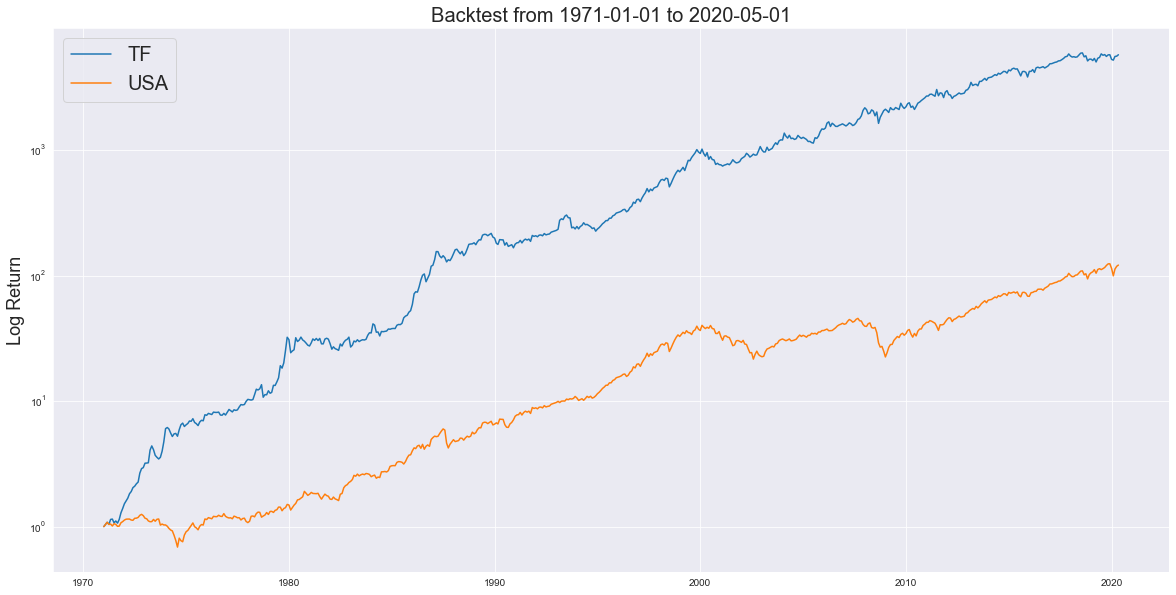

In [16]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result.columns:
    plt.plot(result[i], label = i);
start = datetime.date(result.index.min());    
end = datetime.date(result.index.max());
plt.yscale("log")
plt.ylabel('Log Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

strategy_evaluation(result,['benchmark'] , freq = 'M')

# Test

In [17]:
def TrendFollowing_Backtest(data,benchmark, top_N = 3):
    if len(data.columns) < top_N:
        print('Decrese Top_N or Increse Assets')
    
    else:
        #Calculate Benchmark Return
    
        bench_ret = benchmark.shift(-1)/benchmark - 1
        bench_ret = bench_ret[13:]
        bench_ret = pd.DataFrame(bench_ret)
        
        #Create Momentum frames
        mom_df = data.copy()
        mom3_df=mom_df.apply(lambda x:x/x.shift(3) - 1, axis=0)
        mom6_df=mom_df.apply(lambda x:x/x.shift(6) - 1, axis=0)
        mom12_df=mom_df.apply(lambda x:x/x.shift(12) - 1, axis=0)

        comb_mom_df=mom12_df+mom6_df+mom3_df
    
    
        returns_df=data.copy()
        #shifting returns back to avoid bias
        returns_df=returns_df.apply(lambda x:x.shift(-1)/x - 1, axis=0)
    
        #ranking assets
        rank_df=comb_mom_df.rank(axis=1,ascending=False)
    
        #all top_N assets are choosen
        for col in rank_df.columns:
            rank_df[col]=np.where(rank_df[col]<=top_N, 1, 0)
    
        
        portf=np.multiply(rank_df,returns_df)
        portf_rets=portf.sum(axis =1)/top_N
    
        portf_rets = portf_rets[13:]
        portf_rets = pd.DataFrame(portf_rets)
        portf_rets.columns = ['TF']
    
        result = pd.concat([portf_rets, bench_ret], axis = 1)
        result = result.dropna()
    
    
    
        result = result+1
        result = result.cumprod()
        result = result.astype('float64')

    
        return(result)

In [18]:
#result = TrendFollowing_Backtest(data, data['USA'], top_N = 2)

In [19]:
#result

In [ ]:
returns_df

In [21]:
result

,TF,USA
Date,,
1971-01-01,1.010692,1.010692
1971-02-01,1.052264,1.052264
1971-03-01,1.093654,1.093654
1971-04-01,1.051672,1.051672
1971-05-01,1.153065,1.059401
...,...,...
2020-01-01,5236.388298,114.072253
2020-02-01,5166.520419,99.603826
2020-03-01,5527.450802,112.705629
